# Fitbit Data Analysis 🏃‍♂️📊
# HEART RATE VISUALIZATION

In [1]:
import json
import gzip
import pandas as pd
from datetime import datetime, timedelta
import boto3
from io import BytesIO

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.dates import DateFormatter
import seaborn as sns

In [30]:
# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

#### =============================================================================
## Bucket

In [4]:
session = boto3.Session(profile_name='surface')
s3 = session.client('s3')

In [5]:
bucket_name = 'followcrom'
prefix = 'cromwell/fitbit/'

#### =============================================================================
## Files

In [6]:
s3response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)
files = [obj['Key'] for obj in s3response.get('Contents', [])]
files

['cromwell/fitbit/',
 'cromwell/fitbit/fitbit_backup_2025-10-03.json.gz',
 'cromwell/fitbit/fitbit_backup_2025-10-04.json.gz',
 'cromwell/fitbit/fitbit_backup_2025-10-05.json.gz',
 'cromwell/fitbit/fitbit_backup_2025-10-06.json.gz',
 'cromwell/fitbit/fitbit_backup_2025-10-07.json.gz',
 'cromwell/fitbit/fitbit_backup_2025-10-08.json.gz',
 'cromwell/fitbit/fitbit_backup_2025-10-09.json.gz',
 'cromwell/fitbit/fitbit_backup_2025-10-10.json.gz',
 'cromwell/fitbit/fitbit_backup_2025-10-11.json.gz',
 'cromwell/fitbit/fitbit_backup_2025-10-12.json.gz',
 'cromwell/fitbit/fitbit_backup_2025-10-13.json.gz',
 'cromwell/fitbit/fitbit_backup_2025-10-14.json.gz']

#### =============================================================================
## Select Date

In [7]:
file_key = 'cromwell/fitbit/fitbit_backup_2025-10-10.json.gz'

In [8]:
response = s3.get_object(Bucket=bucket_name, Key=file_key)
with gzip.GzipFile(fileobj=BytesIO(response['Body'].read())) as f:
    data = json.load(f)
print(f"Loaded {len(data):,} records")

Loaded 39,865 records


#### =============================================================================
## All DFs

In [9]:
from functions.parse_data import parse_fitbit_data

In [10]:
# Parse all data
dfs = parse_fitbit_data(data)

# Display summary
print("\n📊 Available DataFrames:")
print("="*60)
for name, df in dfs.items():
    print(f"{name:30s} | {len(df):6d} records | Columns: {list(df.columns)}")


📊 Available DataFrames:
HeartRate_Intraday                       |      38356 records | Columns: ['time', 'Device', 'value']
Steps_Intraday                           |       1440 records | Columns: ['time', 'Device', 'value']
HRV                                      |          1 records | Columns: ['time', 'Device', 'dailyRmssd', 'deepRmssd']
BreathingRate                            |          1 records | Columns: ['time', 'Device', 'value']
SkinTemperature                          |          1 records | Columns: ['time', 'Device', 'nightlyRelative']
Activity-minutesSedentary                |          1 records | Columns: ['time', 'Device', 'value']
Activity-minutesLightlyActive            |          1 records | Columns: ['time', 'Device', 'value']
Activity-minutesFairlyActive             |          1 records | Columns: ['time', 'Device', 'value']
Activity-minutesVeryActive               |          1 records | Columns: ['time', 'Device', 'value']
Activity-steps                        

#### =============================================================================
## HR DFs

In [16]:
df_hr_intra = dfs.get('HeartRate_Intraday', pd.DataFrame())
df_hrv = dfs.get('HRV', pd.DataFrame())
df_hr_zones = dfs.get('HR_Zones', pd.DataFrame())

print(f"✅ Found {len(df_hr_intra)} HeartRate_Intraday records")
print(f"✅ Found {len(df_hrv)} HRV record")
print(f"✅ Found {len(df_hr_zones)} HR Zones record")

✅ Found 38356 HeartRate_Intraday records
✅ Found 1 HRV record
✅ Found 1 HR Zones record


In [17]:
df_hr_intra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38356 entries, 0 to 38355
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype              
---  ------  --------------  -----              
 0   time    38356 non-null  datetime64[ns, UTC]
 1   Device  38356 non-null  object             
 2   value   38356 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(1), object(1)
memory usage: 899.1+ KB


In [12]:
df_hrv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   time        1 non-null      datetime64[ns, UTC]
 1   Device      1 non-null      object             
 2   dailyRmssd  1 non-null      float64            
 3   deepRmssd   1 non-null      float64            
dtypes: datetime64[ns, UTC](1), float64(2), object(1)
memory usage: 160.0+ bytes


In [13]:
df_hr_zones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   time          1 non-null      datetime64[ns, UTC]
 1   Device        1 non-null      object             
 2   Out of Range  1 non-null      float64            
 3   Fat Burn      1 non-null      float64            
 4   Cardio        1 non-null      float64            
 5   Peak          1 non-null      float64            
dtypes: datetime64[ns, UTC](1), float64(4), object(1)
memory usage: 176.0+ bytes


In [19]:
print(df_hr_zones[['time', 'Fat Burn', 'Cardio', 'Peak']].to_string())

                       time  Fat Burn  Cardio  Peak
0 2025-10-10 11:00:00+00:00      18.0     8.0  58.0


In [20]:
import matplotlib.dates as mdates

# Define heart rate zones
zones = {
    'Out of Range': {'range': (0, 93), 'color': '#e8f4f8'},
    'Fat Burn': {'range': (93, 128), 'color': '#fff4e6'},
    'Cardio': {'range': (128, 155), 'color': '#ffe8e8'},
    'Peak': {'range': (155, 220), 'color': '#ffe0e0'}
}

In [21]:
# ============================================================================
# OPTION 1: Heart Rate Timeline with Zone Overlays
# ============================================================================
def plot_hr_with_zones(df_hr_intra, df_hrv):
    """
    Plot intraday heart rate with zone overlays and HRV annotations
    """
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Plot zone bands as background
    for zone_name, zone_info in zones.items():
        ax.axhspan(zone_info['range'][0], zone_info['range'][1], 
                   alpha=0.3, color=zone_info['color'], label=zone_name)
    
    # Plot heart rate line
    ax.plot(df_hr_intra['time'], df_hr_intra['value'], 
            color='#ff4444', linewidth=1.5, label='Heart Rate', zorder=5)
    
    # Add HRV annotations if available
    if not df_hrv.empty:
        hrv_text = f"Daily RMSSD: {df_hrv['dailyRmssd'].iloc[0]:.1f} ms\n"
        hrv_text += f"Deep RMSSD: {df_hrv['deepRmssd'].iloc[0]:.1f} ms"
        ax.text(0.02, 0.98, hrv_text, transform=ax.transAxes,
                verticalalignment='top', bbox=dict(boxstyle='round', 
                facecolor='white', alpha=0.8), fontsize=10)
    
    # Formatting
    ax.set_xlabel('Time', fontsize=12)
    ax.set_ylabel('Heart Rate (bpm)', fontsize=12)
    ax.set_title('Intraday Heart Rate with Zone Overlays', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
    plt.xticks(rotation=45)
    
    # Legend
    handles, labels = ax.get_legend_handles_labels()
    # Reorder to put HR first, then zones
    order = [-1] + list(range(len(handles)-1))
    ax.legend([handles[i] for i in order], [labels[i] for i in order],
              loc='upper right', framealpha=0.9)
    
    plt.tight_layout()
    return fig

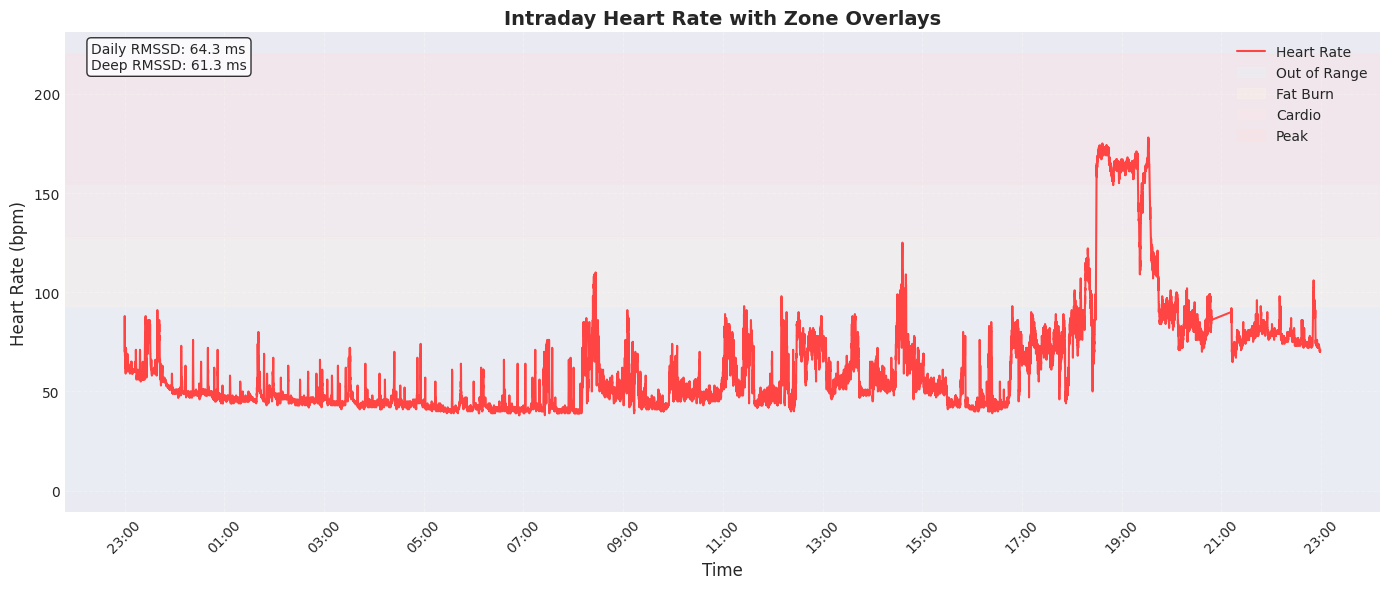

In [22]:
# Figure 1: Heart Rate with Zone Overlays
fig1 = plot_hr_with_zones(df_hr_intra, df_hrv)
plt.show()

In [28]:
# ============================================================================
# OPTION 2: Multi-Panel Dashboard
# ============================================================================
import numpy as np

def plot_dashboard(df_hr_intra, df_hrv, df_hr_zones):
    """
    Create a comprehensive multi-panel dashboard
    """
    fig = plt.figure(figsize=(14, 10))
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)
    
    # Panel 1: Intraday Heart Rate (spans both columns)
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(df_hr_intra['time'], df_hr_intra['value'], 
             color='#ff4444', linewidth=1.5)
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Heart Rate (bpm)')
    ax1.set_title('Intraday Heart Rate', fontweight='bold')
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax1.xaxis.set_major_locator(mdates.HourLocator(interval=2))
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
    
    # Panel 2: HRV Metrics
    ax2 = fig.add_subplot(gs[1, 0])
    if not df_hrv.empty:
        hrv_metrics = ['dailyRmssd', 'deepRmssd']
        hrv_values = [df_hrv[metric].iloc[0] for metric in hrv_metrics]
        bars = ax2.bar(hrv_metrics, hrv_values, color=['#4a90e2', '#50c878'])
        ax2.set_ylabel('RMSSD (ms)')
        ax2.set_title('Heart Rate Variability', fontweight='bold')
        ax2.set_xticklabels(['Daily RMSSD', 'Deep RMSSD'])
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}', ha='center', va='bottom')
    
    # Panel 3: Heart Rate Zone Distribution
    ax3 = fig.add_subplot(gs[1, 1])
    if not df_hr_zones.empty:
        zone_names = ['Out of Range', 'Fat Burn', 'Cardio', 'Peak']
        zone_values = [df_hr_zones[zone].iloc[0] for zone in zone_names]
        colors_list = [zones[zone]['color'] for zone in zone_names]
        bars = ax3.bar(range(len(zone_names)), zone_values, 
                       color=colors_list, edgecolor='black', linewidth=1)
        ax3.set_ylabel('Minutes')
        ax3.set_title('Time in Heart Rate Zones', fontweight='bold')
        ax3.set_xticks(range(len(zone_names)))
        ax3.set_xticklabels(zone_names, rotation=45, ha='right')
        # Add value labels
        for bar in bars:
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.0f}', ha='center', va='bottom')
    
    # Panel 4: Heart Rate Distribution Histogram
    ax4 = fig.add_subplot(gs[2, :])
    hr_values = df_hr_intra['value'].values
    
    # Create histogram with zone colors
    bins = np.arange(df_hr_intra['value'].min(), df_hr_intra['value'].max() + 5, 5)
    n, bins_edges, patches = ax4.hist(hr_values, bins=bins, edgecolor='black', linewidth=0.5)
    
    # Color bars by zone
    for patch, left_edge in zip(patches, bins_edges[:-1]):
        mid_point = left_edge + 2.5
        for zone_name, zone_info in zones.items():
            if zone_info['range'][0] <= mid_point < zone_info['range'][1]:
                patch.set_facecolor(zone_info['color'])
                break
    
    ax4.set_xlabel('Heart Rate (bpm)')
    ax4.set_ylabel('Frequency')
    ax4.set_title('Heart Rate Distribution', fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='y', linestyle='--')
    
    # Add zone lines
    for zone_name, zone_info in zones.items():
        if zone_info['range'][0] > 0:
            ax4.axvline(zone_info['range'][0], color='gray', 
                       linestyle='--', alpha=0.5, linewidth=1)
    
    plt.suptitle('Fitbit Health Dashboard', fontsize=16, fontweight='bold', y=0.995)
    # plt.tight_layout()
    return fig

/tmp/ipykernel_15825/1889422015.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(['Daily RMSSD', 'Deep RMSSD'])


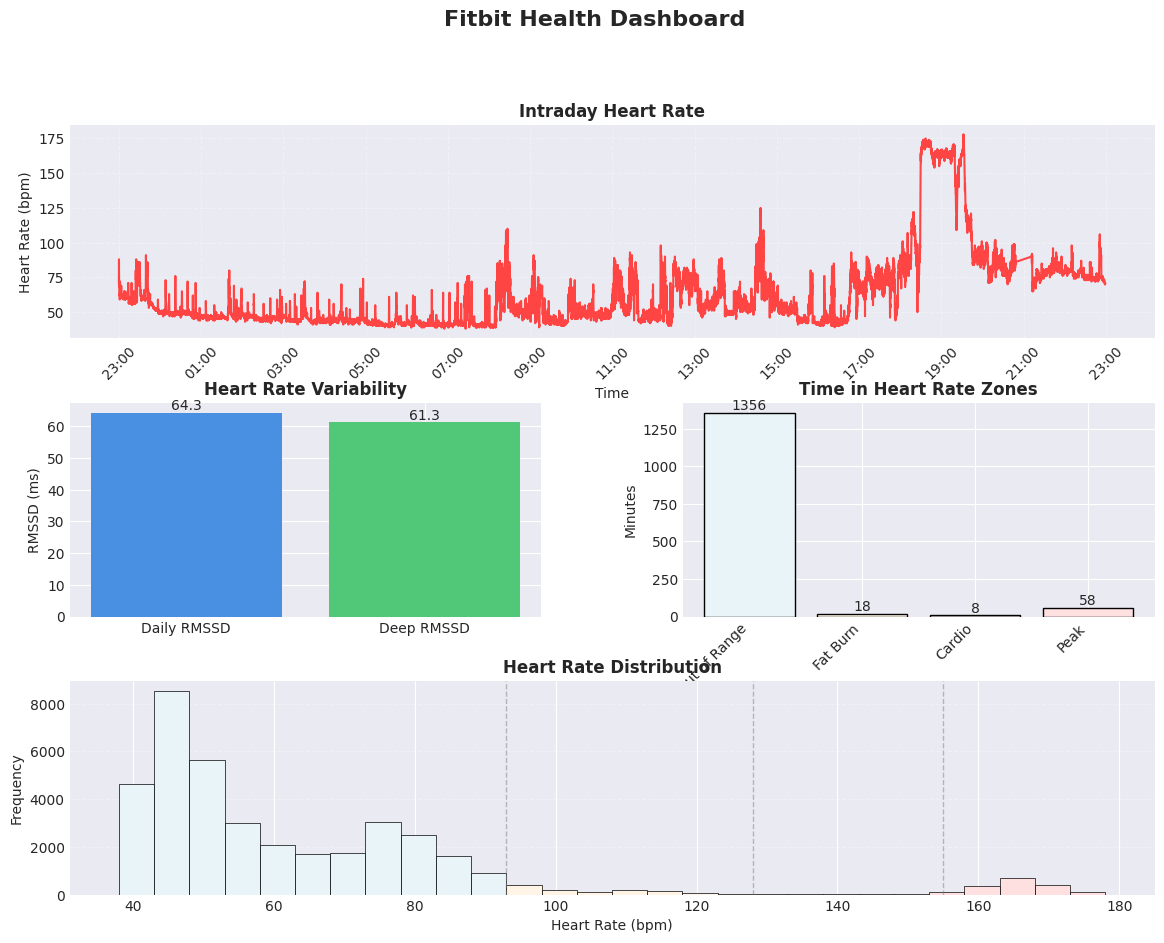

In [29]:
# Figure 2: Multi-Panel Dashboard
fig2 = plot_dashboard(df_hr_intra, df_hrv, df_hr_zones)
plt.show()

In [ ]:
# =============================================================================
# SECTION 4: HEART RATE VISUALIZATION
# =============================================================================

if not df_hr.empty:
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))
    
    # Plot 1: Full time series
    axes[0].plot(df_hr['time'], df_hr['value'], linewidth=0.5, alpha=0.7)
    axes[0].set_title('Heart Rate - Full Time Series', fontsize=16, fontweight='bold')
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('Heart Rate (bpm)')
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Daily average with min/max bands
    df_hr['date'] = df_hr['time'].dt.date
    daily_hr = df_hr.groupby('date')['value'].agg(['mean', 'min', 'max']).reset_index()
    daily_hr['date'] = pd.to_datetime(daily_hr['date'])
    
    axes[1].plot(daily_hr['date'], daily_hr['mean'], marker='o', linewidth=2, label='Daily Average')
    axes[1].fill_between(daily_hr['date'], daily_hr['min'], daily_hr['max'], alpha=0.3, label='Min-Max Range')
    axes[1].set_title('Daily Heart Rate Summary', fontsize=16, fontweight='bold')
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('Heart Rate (bpm)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Heart rate distribution
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.hist(df_hr['value'], bins=50, edgecolor='black', alpha=0.7)
    ax.axvline(df_hr['value'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df_hr["value"].mean():.1f} bpm')
    ax.axvline(df_hr['value'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {df_hr["value"].median():.1f} bpm')
    ax.set_title('Heart Rate Distribution', fontsize=16, fontweight='bold')
    ax.set_xlabel('Heart Rate (bpm)')
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.show()